# Part B: Approximation Problem

This assignment aims to provide you with some exposure to the use of neural networks for regression/approximation problems. Download the California Housing database:

- https://sites.google.com/site/sukritsite/teaching
- http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

This database contains attributes of housing complexes in California such as location, dimensions, etc., together with their corresponding prices. The aim is to predict the housing prices in the test dataset after training the neural networks on other attributes in the training data. Read the data from the file ‘california_housing.data’.

This is a model selection task, i.e. you have to try out different parameters for the neural network, forming different models and select the one which gives you highest accuracy. Divide the data into test and train set at a ratio of 0.3: 0.7. You need to scale and normalise only the input features in the data to zero mean and unit standard deviation. You need to perform 5-fold cross-validation on the train data in order to select the best models. For this, you will further divide the train data into five folds.

Each data sample is a row of 9 values: 8 input attributes and median housing price.

## Preparation

To build the model first we need to preprocess the data. The following is the code to preprocess the [cal_housing.data](housing_data/cal_housing.data).
Start with the utility used by the Preprocessor.

In [1]:
import numpy as np

def scale(data):
    """ scale data (from begin_project_1b.py) """
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return (data - data_min)/(data_max - data_min)

def normalize(data):
    """ normalize data (from begin_project_1b.py) """
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    return (data - data_mean)/data_std

Then the Preprocessor class to load data, divide it into training and test set and then finally normalize the data.

In [2]:
class Preprocessor:
    """ Preprocess class """

    def __init__(self):
        self.x_data = None
        self.y_data = None
        self.test_x = None
        self.test_y = None
        self.train_x = None
        self.train_y = None
        return


    def load_data(self, data_dir):
        """ Load data from data_dir """
        temp_data = np.loadtxt(data_dir, delimiter=',')
        self.x_data = temp_data[:,:8]
        self.y_data = Y_data = (np.asmatrix(temp_data[:,-1])).transpose()

    def divide_data(self, test_count, train_count):
        """ Divide data into training and test set """
        div_count = (test_count * self.x_data.shape[0]) // (test_count + train_count)
        self.test_x = self.x_data[:div_count]
        self.test_y = self.y_data[:div_count]
        self.train_x = self.x_data[div_count:]
        self.train_y = self.y_data[div_count:]

    def normalize_data(self):
        """ Scale and Normalize test and train data """
        self.test_x = scale(self.test_x)
        self.train_x = scale(self.train_x)

        self.test_x = normalize(self.test_x)
        self.train_x = normalize(self.train_x)
        

Next will be the approximation model. Start with the utility function used by the Approximation Class

In [3]:
import theano

FLOAT_X = theano.config.floatX

def shuffle_data(samples, labels):
    """ Shuffle data (from begin_project_1b.py) """
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    samples, labels = samples[idx], labels[idx]
    return samples, labels

def get_weigh(prev_layer, cur_layer):
    """ get weigh """
    return theano.shared(np.random.randn(prev_layer, cur_layer)*0.01, FLOAT_X)

def get_bias(cur_layer):
    """ get weigh """
    return theano.shared(np.random.randn(cur_layer)*0.01, FLOAT_X)

def get_fold_data(data, fold_num):
    """ split the data into different fold """
    train = []
    validation = []
    for i in range(len(data)):
        if i == fold_num:
            validation = data[i]
        else:
            if len(train) == 0:
                train = data[i]
            else:
                train = np.concatenate((train, data[i]))

    return train, validation

The following is the class for Approximation. Using mini-batch gradient descent and k-fold cross validation for model selection

In [1]:
import time

import theano.tensor as T

class Approximation:
    """ Approximation Class """

    def __init__(self):
        self.train = None
        self.test = None

        self.train_x = None
        self.train_y = None
        self.test_x = None
        self.test_y = None

    def select_model(self, train_x, train_y, k_fold, epochs, batch_size, hidden_neurons, learning_rate):
        """ select model using K-Fold cross validation """
        data_fold_x = []
        data_fold_y = []

        div_count = train_x.shape[0] // k_fold

        for i in range(k_fold):
            data_fold_x.append(train_x[i*div_count:(i+1)*div_count])
            data_fold_y.append(train_y[i*div_count:(i+1)*div_count])

        min_err = 1e+15
        best_train_x = None
        best_train_y = None

        list_train_cost = []
        list_test_cost = []
        list_test_accuracy = []

        for i in range(k_fold):
            self.train_x, self.test_x = get_fold_data(data_fold_x, i)
            self.train_y, self.test_y = get_fold_data(data_fold_y, i)
            
            self.create_model(hidden_neurons, learning_rate)
            train_cost, test_cost, test_accuracy, new_err = self.train_model(epochs, batch_size)
            
            list_train_cost.append(train_cost)
            list_test_cost.append(test_cost)
            list_test_accuracy.append(test_accuracy)

            if new_err < min_err:
                min_err = new_err
                best_train_x = self.train_x
                best_train_y = self.train_y

        self.train_x = best_train_x
        self.train_y = best_train_y
        return list_train_cost, list_test_cost, list_test_accuracy, min_err
    
    def create_model(self, list_of_neurons_on_hidden_layer, learning_rate):
        """ Create model from list of neurons """
        no_features = self.train_x.shape[1] 
        
        input_x = T.matrix('x') # data sample
        expected_y = T.matrix('d') # desired output

        alpha = theano.shared(learning_rate, FLOAT_X) 

        # initialize weights and biases for hidden layer(s) and output layer
        weights = []
        biases = []
        prev_layer = no_features

        for cur_layer in list_of_neurons_on_hidden_layer + [1]:
            weights.append(get_weigh(prev_layer, cur_layer))
            biases.append(get_bias(cur_layer))
            prev_layer = cur_layer

        # Define mathematical expression:
        h_out = input_x
        for w,b in zip(weights[:-1], biases[:-1]):
            h_out = T.nnet.sigmoid(T.dot(h_out, w) + b)

        h_out = T.dot(h_out, weights[-1]) + biases[-1]

        cost = T.abs_(T.mean(T.sqr(expected_y - h_out)))
        accuracy = T.mean(expected_y - h_out)

        #define gradients
        updates = []
        grad = T.grad(cost, weights + biases)
        grad_w = grad[:len(grad)//2]
        grad_b = grad[len(grad)//2:]
        for i in range(len(weights)):
            updates.append([weights[i], weights[i] - alpha * grad_w[i]])
            updates.append([biases[i], biases[i] - alpha * grad_b[i]])

        self.train = theano.function(
            inputs = [input_x, expected_y],
            outputs = cost,
            updates = updates,
            allow_input_downcast=True
            )

        self.test = theano.function(
            inputs = [input_x, expected_y],
            outputs = [h_out, cost, accuracy],
            allow_input_downcast=True
            )

    def train_model(self, epochs, batch_size, verbose=False):
        """ train model based on self.train_x and self.train_y """
        train_cost = np.zeros(epochs)
        test_cost = np.zeros(epochs)
        test_accuracy = np.zeros(epochs)

        min_error = 1e+15
        
        start_time = time.time()

        for iter in range(epochs):
            self.train_x, self.train_y = shuffle_data(self.train_x, self.train_y)
            train_cost[iter] = self.training_iter(batch_size)
            _, test_cost[iter], test_accuracy[iter] = self.test_model()

#             if iter%1000 == 0:
#                 print("Iter: ", iter)
#                 print("- Train MSE: ", train_cost[iter])
#                 print("- Test MSE: ", test_cost[iter])
#                 print("----------------------------------------------------------------------")
            
            if test_cost[iter] < min_error:
                min_error = test_cost[iter]
                
        exec_time = time.time() - start_time
        if verbose:
            print("Finished training --> Minimum Error: ", min_error)
            print("- Epoch: ", epochs)
            print("- Batch Size: ", batch_size)
            print("----------------------------------------------------------------------")
        
        return train_cost, test_cost, test_accuracy, min_error

    def training_iter(self, batch_size):
        cost = []

        for i in range(0, len(self.train_x), batch_size):
            end = i + batch_size
            if end > len(self.train_x):
                end = len(self.train_x)

            train_x_batch = self.train_x[i:end]
            train_y_batch = self.train_y[i:end]

            cost.append(self.train(train_x_batch, train_y_batch))
            
        return np.mean(cost)

    def test_model(self):
        """ test model using independent test data """
        return self.test(self.test_x, self.test_y)

    def set_x_train(self, train_x):
        """ self.train_x setter """
        self.train_x = train_x

    def set_y_train(self, train_y):
        """ self.train_y setter """
        self.train_y = train_y

    def set_x_test(self, test_x):
        """ self.test_x setter """
        self.test_x = test_x

    def set_y_test(self, test_y):
        """ self.test_y setter """
        self.test_y = test_y

        

Finally, the last is the visualization class. It will support plotting multiple graph in one figure (as long as using the same x range)

In [5]:
import matplotlib.pyplot as plt

def plot_graph(title, x_label, y_label, x_val, y_vals, data_labels, save_fig="", show_graph=True):
    """ Plot graphs using matplotlib """
    plt.figure()

    for i in range(len(data_labels)):
        plt.plot(x_val, y_vals[i], label=data_labels[i])

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    if save_fig != "":
        plt.savefig(save_fig)

    if show_graph:
        plt.show()


## Question 1

Design a 3-layer feedforward neural network consisting of a hidden-layer of 30 neurons. Use mini-batch gradient descent (with batch size of 32 and learning rate = 10−4) to train the network. Use up to about 1000 epochs for this problem.

- Plot the training error against number of epochs for the 3-layer network.
- Plot the final test errors of prediction by the network.

Start Question 1


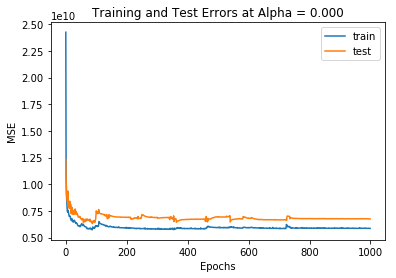

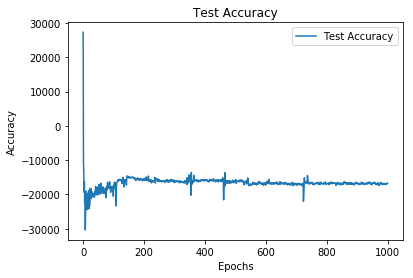

In [6]:
def main():
    print("Start Question 1")
    np.random.seed(10)

    k_fold = 5
    hidden_neurons = [30]
    batch_size = 32
    learning_rate = 1e-4
    epochs = 1000
    data_dir = "housing_data/cal_housing.data"

    # Preprocessing: Load data
    preprocessor = Preprocessor()
    preprocessor.load_data(data_dir)
    preprocessor.divide_data(3, 7)
    preprocessor.normalize_data()

    nn = Approximation()

    if k_fold > 0:
        list_train_cost, list_test_cost, list_test_accuracy, min_err = nn.select_model(
            train_x = preprocessor.train_x,
            train_y = preprocessor.train_y,
            k_fold = k_fold,
            epochs = epochs,
            batch_size = batch_size,
            hidden_neurons = hidden_neurons,
            learning_rate = learning_rate
        )
        # TODO:
        # Plot K-fold graphs

    else:
        nn.set_x_train(preprocessor.train_x)
        nn.set_y_train(preprocessor.train_y)
    
    nn.set_x_test(preprocessor.test_x)
    nn.set_y_test(preprocessor.test_y)
    nn.create_model(hidden_neurons, learning_rate)
    train_cost, test_cost, accuracy, min_err = nn.train_model(epochs=epochs, batch_size=batch_size, verbose=True)

    # Plot training error against number of epoch
    # Plot test error of prediction against number of epoch
    plot_graph(
        title='Training and Test Errors at Alpha = %.3f'%learning_rate,
        x_label="Epochs",
        y_label="MSE",
        x_val=range(epochs),
        y_vals=[train_cost, test_cost],
        data_labels=["train", "test"],
    )

    # Plot accuracy against number of epoch
    plot_graph(
        title="Test Accuracy",
        x_label="Epochs",
        y_label="Accuracy",
        x_val=range(epochs),
        y_vals=[accuracy],
        data_labels=["Test Accuracy"],
    )

if __name__ == '__main__':
    main()

From the graph of train and test mean squared errors we can see the following:

- Train set error is better compared to the test set because the model will try to fit into the train set.
- We also can see some fluctuation (e.g. arround epoch-100) that indicates the models is already overfitting to the train set. It may be caused by the small number of data and too many iterations.
- The fluctuation also caused by the mini-batch gradient descent. Because the batch size is relatively small (batch = 32), the model try to change a lot.

## Question 2

Find the optimal learning rate for the 3-layer network designed. Set this as the learning rate in first hidden layer for the rest of the experiments.

- Plot the training errors and validation errors against number of epochs for the 3-layer network for different learning rates. Limit the search space to: {10e−3, 0.5 × 10e−3, 10e−4, 0.5 × 10e−4, 10e−5}
- Plot the test errors against number of epochs for the optimum learning rate.
- State the rationale behind selecting the optimal learning rate.

Start Question 2


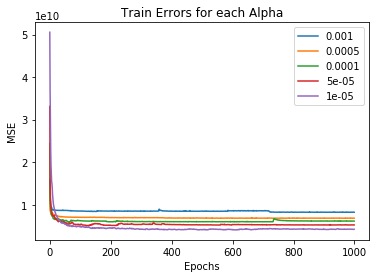

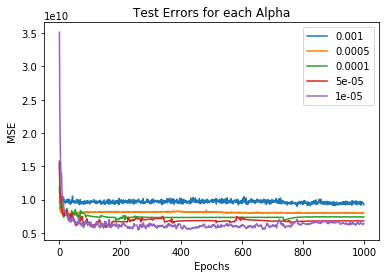

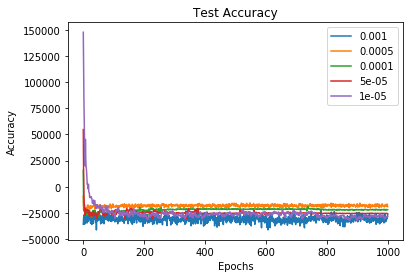

In [7]:
def main():
    print("Start Question 2")
    np.random.seed(10)

    k_fold = 5
    hidden_neurons = [30]
    batch_size = 32
    learning_rate_list = [1e-3, 0.5 * 1e-3, 1e-4, 0.5 * 1e-4, 1e-5]
    epochs = 1000
    data_dir = "housing_data/cal_housing.data"

    # Preprocessing: Load data
    preprocessor = Preprocessor()
    preprocessor.load_data(data_dir)
    preprocessor.divide_data(3, 7)
    preprocessor.normalize_data()

    list_train_cost = []
    list_test_cost = []
    list_test_accuracy = []
    nn = Approximation()

    for learning_rate in learning_rate_list:
        if k_fold > 0:
            nn.select_model(
                train_x = preprocessor.train_x,
                train_y = preprocessor.train_y,
                k_fold = k_fold,
                epochs = epochs,
                batch_size = batch_size,
                hidden_neurons = hidden_neurons,
                learning_rate = learning_rate
            )

        else:
            nn.set_x_train(preprocessor.train_x)
            nn.set_y_train(preprocessor.train_y)
        
        nn.set_x_test(preprocessor.test_x)
        nn.set_y_test(preprocessor.test_y)
        nn.create_model(hidden_neurons, learning_rate)
        train_cost, test_cost, test_accuracy, min_err = nn.train_model(epochs=epochs, batch_size=batch_size, verbose=True)
        list_train_cost.append(train_cost)
        list_test_cost.append(test_cost)
        list_test_accuracy.append(test_accuracy)

    # Plot training error against number of epoch
    plot_graph(
        title='Train Errors for each Alpha',
        x_label="Epochs",
        y_label="MSE",
        x_val=range(epochs),
        y_vals=list_train_cost,
        data_labels=learning_rate_list,
    )

    # Plot test error of prediction against number of epoch
    plot_graph(
        title='Test Errors for each Alpha',
        x_label="Epochs",
        y_label="MSE",
        x_val=range(epochs),
        y_vals=list_test_cost,
        data_labels=learning_rate_list,
    )

    # Plot accuracy against number of epoch
    plot_graph(
        title="Test Accuracy",
        x_label="Epochs",
        y_label="Accuracy",
        x_val=range(epochs),
        y_vals=list_test_accuracy,
        data_labels=learning_rate_list,
    )

if __name__ == '__main__':
    main()

For this question we choose 1e-5 as the best learning rates. The following are the reasons:

- Learning rate determine how fast the the model move to the optimal weights. If learning rate very large there are possibility to skip optimal weight. But if the learning rate very small the model will need many iteration to achieve the optimal weights.
- So, as we can see from the train MSE, the training with 1e-5 learning rate (lowest) have the best MSE. But at the same time the iteration needed to reach the optimal weights is more compare to the rest.
- But because after less than 100 iterations the MSE already converge then in real life still can be considered as fast. So 1e-5 will be the best learning rates

Actually the best way to set learning rate is the adapting learning rate in each iteration. The idea is larger learning rate when the models is still far from optimal and smaller learning rate as the models approaching optimal. But this will be a bit tricky in real life because we do not know the optimal value, hence we do not know how far we are from the optimal. Several ways already developed to simulate how far the model from optimal values such as [Bold Driver](http://www.willamette.edu/~gorr/classes/cs449/momrate.html)

## Question 3

Find the optimal number of hidden neurons for the 3-layer network designed.    

- Plot the training errors against number of epochs for the 3-layer network for different hidden-layer neurons. Limit search space to:{20,30,40,50,60}.
- Plot the test errors against number of epochs for the optimum number of hiddenlayer neurons.
- State the rationale behind selecting the optimal number of hidden neurons

Start Question 3


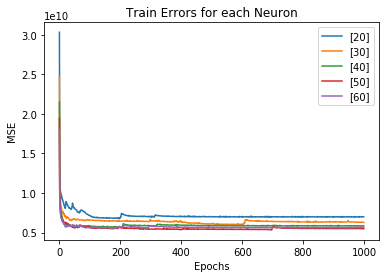

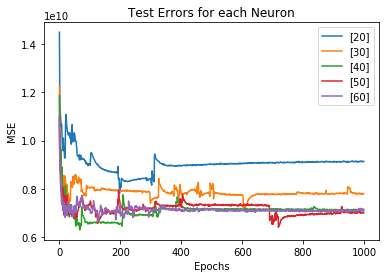

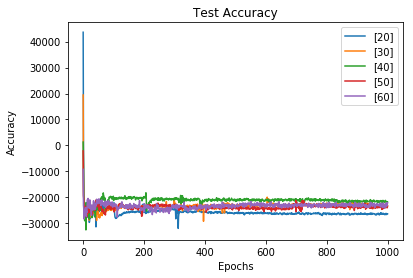

In [8]:
def main():
    print("Start Question 3")
    np.random.seed(10)

    k_fold = 5
    hidden_neuron_list = [[20], [30], [40], [50], [60]]
    batch_size = 32
    learning_rate = 1e-4
    epochs = 1000
    data_dir = "housing_data/cal_housing.data"

    # Preprocessing: Load data
    preprocessor = Preprocessor()
    preprocessor.load_data(data_dir)
    preprocessor.divide_data(3, 7)
    preprocessor.normalize_data()

    list_train_cost = []
    list_test_cost = []
    list_test_accuracy = []
    nn = Approximation()

    for hidden_neurons in hidden_neuron_list:
        if k_fold > 0:
            nn.select_model(
                train_x = preprocessor.train_x,
                train_y = preprocessor.train_y,
                k_fold = k_fold,
                epochs = epochs,
                batch_size = batch_size,
                hidden_neurons = hidden_neurons,
                learning_rate = learning_rate
            )

        else:
            nn.set_x_train(preprocessor.train_x)
            nn.set_y_train(preprocessor.train_y)
        
        nn.set_x_test(preprocessor.test_x)
        nn.set_y_test(preprocessor.test_y)
        nn.create_model(hidden_neurons, learning_rate)
        train_cost, test_cost, test_accuracy, min_err = nn.train_model(epochs=epochs, batch_size=batch_size, verbose=True)
        list_train_cost.append(train_cost)
        list_test_cost.append(test_cost)
        list_test_accuracy.append(test_accuracy)

    # Plot training error against number of epoch
    plot_graph(
        title='Train Errors for each Neuron',
        x_label="Epochs",
        y_label="MSE",
        x_val=range(epochs),
        y_vals=list_train_cost,
        data_labels=hidden_neuron_list,
    )

    # Plot test error of prediction against number of epoch
    plot_graph(
        title='Test Errors for each Neuron',
        x_label="Epochs",
        y_label="MSE",
        x_val=range(epochs),
        y_vals=list_test_cost,
        data_labels=hidden_neuron_list,
    )

    # Plot accuracy against number of epoch
    plot_graph(
        title="Test Accuracy",
        x_label="Epochs",
        y_label="Accuracy",
        x_val=range(epochs),
        y_vals=list_test_accuracy,
        data_labels=hidden_neuron_list,
    )

if __name__ == '__main__':
    main()

For this question we choose 60 as the optimal number of the hidden neurons. The following are the reasons:

- Optimal number of hidden neurons depends on the data set and behaviour so there is no golden rule to determine the optimal number of the hidden neurons. 
- As we can see from the train MSE the models with 60 hidden neurons performe metter compared to the other method. The only limitation here is the execution time or the resources. Larger number of hidden neurons will have more execution time and consume more resurces.
- But because there are only 1 hidden layer so the execution time does not vary much. Hence 60 is selected as the optimal hidden neurons

One of the most-used rule to determine the number of hidden neurons is between input features and number of output (e.g. average). But in this case if we try value between 8 (input features) and 1 (output) it will performed worse than the tested value. It may be because of the domain knowledge. Naturally to determine price of a house the given input feature is not enough. That's why the rule does not work on this case. But the learning will be smoother using value between 8 and 1. 

## Question 4

Design a four-layer neural network and a five-layer neural network, with the first hidden layer having number of neurons found in step (3) and other hidden layers having 20 neurons each. Use a learning rate = 10−4. Plot the test errors of the 4-layer network and 5-layer network, and compare them with that of the 3-layer network.

Start Question 4


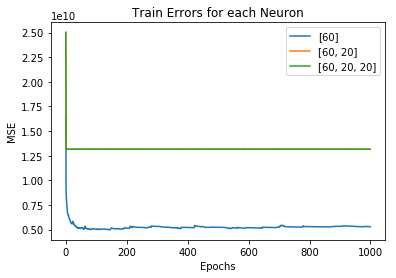

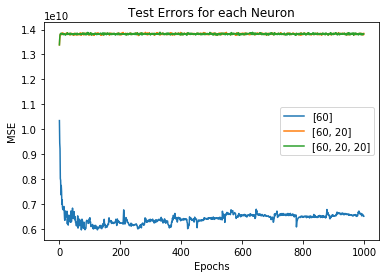

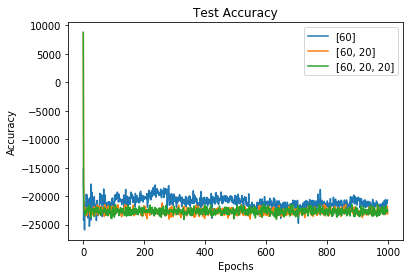

In [28]:
def main():
    print("Start Question 4")
    np.random.seed(10)

    k_fold = 0
    hidden_neuron_list = [[60], [60, 20], [60, 20, 20]]
    batch_size = 32
    learning_rate = 1e-4
    epochs = 1000
    data_dir = "housing_data/cal_housing.data"

    # Preprocessing: Load data
    preprocessor = Preprocessor()
    preprocessor.load_data(data_dir)
    preprocessor.divide_data(3, 7)
    preprocessor.normalize_data()

    list_train_cost = []
    list_test_cost = []
    list_test_accuracy = []
    nn = Approximation()

    for hidden_neurons in hidden_neuron_list:
        if k_fold > 0:
            nn.select_model(
                train_x = preprocessor.train_x,
                train_y = preprocessor.train_y,
                k_fold = k_fold,
                epochs = epochs,
                batch_size = batch_size,
                hidden_neurons = hidden_neurons,
                learning_rate = learning_rate
            )

        else:
            nn.set_x_train(preprocessor.train_x)
            nn.set_y_train(preprocessor.train_y)
        
        nn.set_x_test(preprocessor.test_x)
        nn.set_y_test(preprocessor.test_y)
        nn.create_model(hidden_neurons, learning_rate)
        train_cost, test_cost, test_accuracy, min_err = nn.train_model(epochs=epochs, batch_size=batch_size, verbose=True)
        list_train_cost.append(train_cost)
        list_test_cost.append(test_cost)
        list_test_accuracy.append(test_accuracy)

    # Plot training error against number of epoch
    plot_graph(
        title='Train Errors for each Neuron',
        x_label="Epochs",
        y_label="MSE",
        x_val=range(epochs),
        y_vals=list_train_cost,
        data_labels=hidden_neuron_list,
    )

    # Plot test error of prediction against number of epoch
    plot_graph(
        title='Test Errors for each Neuron',
        x_label="Epochs",
        y_label="MSE",
        x_val=range(epochs),
        y_vals=list_test_cost,
        data_labels=hidden_neuron_list,
    )

    # Plot accuracy against number of epoch
    plot_graph(
        title="Test Accuracy",
        x_label="Epochs",
        y_label="Accuracy",
        x_val=range(epochs),
        y_vals=list_test_accuracy,
        data_labels=hidden_neuron_list,
    )

if __name__ == '__main__':
    main()

For this question we can compare the performance of the network with 4 and 5 layer with network with 3 ayer. From the train MSE graph we can see that the network with 4 and 5 layer almost performed very similar. Both of them performed worse compare to the 3-layer network. This probably caused by overfitting. The 4-layer and 5-layer network is too complicated for the data set. The data set only have 8 feature and 1 output. So increasing the number of network may cause the model become not suitable for the data. With this 3-layer network is enough to build the model.